In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers as opt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import losses
import pandas as pd
import seaborn as sns
import shap

In [2]:
DATA_PATH="./Vowel_Data/Formant/"
n_time_sample=50

In [3]:
seed=0

In [4]:
def get_formant(file_path,max_len=n_time_sample):
    formant=pd.read_csv(file_path,
                delim_whitespace=True,
                header=None,
                names=["time","F1","F2","F3","F4","F5"],
                dtype=np.float64,
                na_values="--undefined--")
    
    if (max_len > formant.shape[0]):
        required_rows=max_len-formant.shape[0]
        new_data=pd.DataFrame(np.zeros((required_rows,6)),columns=["time","F1","F2","F3","F4","F5"])  #empty structure to configure
        time_step=formant.iloc[1]['time']-formant.iloc[0]['time']
        new_data['time']=[formant.iloc[-1]['time']+i*time_step for i in range(1,required_rows+1)]   #new time will incremented as previous time data
        new_data.iloc[:,1:]=formant.iloc[-1,1:].values  #formant values of last existing sample is taken as new formant values
        formant=formant.append(new_data,ignore_index=True)  #new data is appended to the existing
    else:
        formant=formant.iloc[:max_len]  #truncate up to fixed length
        
    return formant

def get_all_formants(path=DATA_PATH):
    labels=labels=sorted(os.listdir(path))
    all_formant=pd.DataFrame() #empty dataframe to store all_formants
    
    for label_index,label in enumerate(labels):
        folder_formant=pd.DataFrame() #empty dataframe to store formants of indivuals vowels/words i.e. folders

        formant_files=[path + label + '/' + file for file in sorted(os.listdir(path+'/'+label))]
        for file in tqdm(formant_files,"Reading Formants of label -'{}'".format(label)):
            #print(file)
            individual_formant=get_formant(file_path=file)
  
            length=len(individual_formant)
            F_i=individual_formant.loc[2:,'F1':'F5'].values
            F_i1=individual_formant.loc[1:length-2,'F1':'F5'].values
            F_i2=individual_formant.loc[:length-3,'F1':'F5'].values
            assert len(F_i)==len(F_i1)==len(F_i2)
            individual_formant.loc[2:,['F1_diff2','F2_diff2','F3_diff2','F4_diff2','F5_diff2']]=F_i-2*F_i1+F_i2
            
            individual_formant=individual_formant.dropna()   #drop the first two rows as there are NaN values due to the difference
            
            folder_formant=folder_formant.append(individual_formant,ignore_index=True)
        
        folder_formant['disp(F5-F1)']=folder_formant['F5']-folder_formant['F1']
        folder_formant['disp(F4-F3)']=folder_formant['F4']-folder_formant['F3']
        folder_formant['disp(F5-F3)']=folder_formant['F5']-folder_formant['F3']
        folder_formant['disp(F5-F4)']=folder_formant['F5']-folder_formant['F4']
        
        folder_formant['label']=label_index  #new columns for encoding label
        
        all_formant=all_formant.append(folder_formant,ignore_index=True)     
    return all_formant

def get_train_test(split_ratio=0.8,random_state=42):
    all_formants=get_all_formants()
    
    y=all_formants['label'].values
 
    only_formants=all_formants.drop(labels=['label'],axis=1)
    
    normalized_formants=(only_formants-only_formants.mean())/only_formants.std()
    
    X=normalized_formants.values   

    assert X.shape[0] == len(y)
    return train_test_split(X,y,test_size=(1-split_ratio),random_state=random_state,shuffle=True,stratify=y)

In [39]:
path=DATA_PATH
labels=sorted(os.listdir(path))

In [100]:
for label in labels:
    formant_vectors=[]

    formant_files=[path + label + '/' + file for file in sorted(os.listdir(path+'/'+label))]
    for file in tqdm(formant_files,"Saving vectors to label -'{}'".format(label)):
        #print(file)
        individual_formant=get_formant(file_path=file)
  
        length=len(individual_formant)
        #F_i=individual_formant.loc[2:,'F1':'F5'].values    #current value, 2 because for 0 and 1, no backward difference will be found
        #F_i1=individual_formant.loc[1:length-2,'F1':'F5'].values    #F_(i-1)
        #F_i2=individual_formant.loc[:length-3,'F1':'F5'].values     #F_(i-2)
        #assert len(F_i)==len(F_i1)==len(F_i2)   #all lengths should be equal so that i the below matrix operation will be justified
        
        #backward difference formula to calculate transition
        #individual_formant.loc[2:,['F1_diff2','F2_diff2','F3_diff2','F4_diff2','F5_diff2']]=F_i-2*F_i1+F_i2
        
        #individual_formant=individual_formant.dropna()   #drop the first two rows as there are NaN values due to the difference        
        individual_formant=individual_formant.drop(labels=['time'],axis=1)  #drop the time axis as it doesn't contain any variation among different class
        
        #Calculating 4 dispersions
        #individual_formant['disp(F5-F1)']=individual_formant['F5']-individual_formant['F1']
        #individual_formant['disp(F4-F3)']=individual_formant['F4']-individual_formant['F3']
        #individual_formant['disp(F5-F3)']=individual_formant['F5']-individual_formant['F3']
        #individual_formant['disp(F5-F4)']=individual_formant['F5']-individual_formant['F4']
        
        #Normalizing values because the values are at different range
        #normalized_formants=(individual_formant-individual_formant.mean())/individual_formant.std()
        
        formant_vectors.append(normalized_formants.values)  #array values are appended on a list...length of this list is equal to number of files in each file
        # and each array should be size of (n_time_sample-2*14); 2 subtracted because first 2 columns are dropped, 14 includes 5 formants, 5 transition, 4 displacements
            
    np.save(label+'.npy',formant_vectors)

Saving vectors to label -'Formant7': 100%|██████████| 40/40 [00:00<00:00, 142.65it/s]


In [26]:
individual_formant.drop(labels=['time'],axis=1)

,F1,F2,F3,F4,F5,F1_diff2,F2_diff2,F3_diff2,F4_diff2,F5_diff2
2,670.76,1514.62,2428.13,3774.71,4719.93,-20.25,-21.72,96.00,-2.56,-64.24
3,666.49,1524.23,2439.99,3764.21,4651.84,23.46,-8.50,-49.74,-63.77,-1.82
4,667.40,1524.64,2409.82,3699.78,4696.84,5.18,-9.20,-42.03,-53.93,113.09
5,670.96,1467.74,2412.33,3627.49,4665.41,2.65,-57.31,32.68,-7.86,-76.43
6,672.48,1450.46,2466.67,3667.72,4667.02,-2.04,39.62,51.83,112.52,33.04
7,670.78,1475.98,2495.13,3872.98,4628.13,-3.22,42.80,-25.88,165.03,-40.50
8,674.67,1468.56,2533.50,3954.55,4629.81,5.59,-32.94,9.91,-123.69,40.57
9,669.63,1506.34,2543.45,3935.89,4647.01,-8.93,45.20,-28.42,-100.23,15.52
10,670.61,1555.54,2573.87,3884.07,4656.87,6.02,11.42,20.47,-33.16,-7.34
11,662.47,1540.89,2563.99,3938.86,4695.31,-9.12,-63.85,-40.30,106.61,28.58


In [35]:
len(formant_vectors)

40

In [36]:
formant_vectors[0].shape

(48, 14)

In [101]:
X=np.load(labels[0]+'.npy')
y=np.zeros(X.shape[0])

In [102]:
y.shape

(40,)

In [103]:
for i,label in enumerate(labels[1:]):
    x=np.load(label+'.npy')
    X=np.vstack((X,x))    #Virtually stacka all X's..the size of final X will be (total_files*shape_of_formant_vectors)
    y=np.append(y,np.full(x.shape[0],fill_value=(i+1)))   #labelling all classes
assert X.shape[0] == len(y)

In [46]:
X.shape

(280, 48, 14)

In [104]:
X_train_raw, X_test_raw, y_train, y_test=train_test_split(X,y,test_size=0.1,random_state=42,shuffle=True,stratify=y)

In [105]:
X_train.shape

(252, 672)

In [106]:
X_train=X_train_raw.reshape(X_train_raw.shape[0],-1)
X_test=X_test_raw.reshape(X_test_raw.shape[0],-1)

In [107]:
X_test.shape[1]

672

In [108]:
#X_train, X_test, y_train, y_test=get_train_test()
y_train_hot=to_categorical(y_train)
y_test_hot=to_categorical(y_test)

In [109]:
np.random.seed(seed)

In [110]:
model_v=Sequential()
model_v.add(Dense(512, activation='tanh', input_shape=(X_train.shape[1],)))
model_v.add(Dense(256, activation='tanh'))
model_v.add(Dense(128, activation='tanh'))
model_v.add(Dense(64, activation='tanh'))
model_v.add(Dense(32, activation='tanh'))
model_v.add(Dense(16, activation='tanh'))
model_v.add(Dense(7, activation='softmax'))

In [111]:
model_v.compile(
    #optimizer=opt.SGD(learning_rate=0.005,momentum=0.9),
    optimizer=opt.Adam(learning_rate=0.00),
    #loss=losses.CategoricalCrossentropy(),
    loss='categorical_crossentropy',
    #metrics=['AUC'],
    #metrics=['accuracy']#,
    metrics=[['accuracy','AUC']]
)

In [112]:
history_v=model_v.fit(X_train, y_train_hot, epochs=50, batch_size=X_train.shape[0], validation_data=(X_test,y_test_hot))

Epoch 1/50
1/1 [==============================] - 0s 318ms/step - loss: 2.1730 - accuracy: 0.1429 - auc: 0.5000 - val_loss: 2.4976 - val_accuracy: 0.1429 - val_auc: 0.5000
Epoch 2/50
1/1 [==============================] - 0s 59ms/step - loss: 2.4976 - accuracy: 0.1429 - auc: 0.5000 - val_loss: 2.1055 - val_accuracy: 0.1429 - val_auc: 0.5000
Epoch 3/50
1/1 [==============================] - 0s 61ms/step - loss: 2.1055 - accuracy: 0.1429 - auc: 0.5000 - val_loss: 2.0315 - val_accuracy: 0.1429 - val_auc: 0.5000
Epoch 4/50
1/1 [==============================] - 0s 53ms/step - loss: 2.0315 - accuracy: 0.1429 - auc: 0.5000 - val_loss: 1.9755 - val_accuracy: 0.1429 - val_auc: 0.5000
Epoch 5/50
1/1 [==============================] - 0s 51ms/step - loss: 1.9755 - accuracy: 0.1429 - auc: 0.5000 - val_loss: 1.9663 - val_accuracy: 0.1429 - val_auc: 0.5000
Epoch 6/50
1/1 [==============================] - 0s 50ms/step - loss: 1.9663 - accuracy: 0.1429 - auc: 0.5000 - val_loss: 1.9598 - val_accuracy

Epoch 49/50
1/1 [==============================] - 0s 45ms/step - loss: 1.9460 - accuracy: 0.1429 - auc: 0.5000 - val_loss: 1.9460 - val_accuracy: 0.1429 - val_auc: 0.5000
Epoch 50/50
1/1 [==============================] - 0s 35ms/step - loss: 1.9460 - accuracy: 0.1429 - auc: 0.5000 - val_loss: 1.9460 - val_accuracy: 0.1429 - val_auc: 0.5000


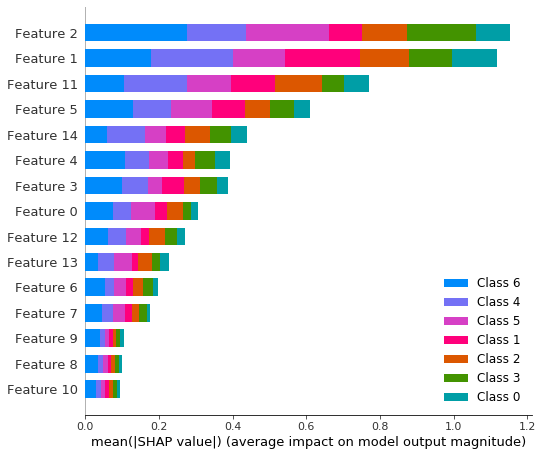

In [72]:
e=shap.DeepExplainer(model_v,X_test)
shape_values=e.shap_values(X_test)
shap.summary_plot(shape_values,X_test)

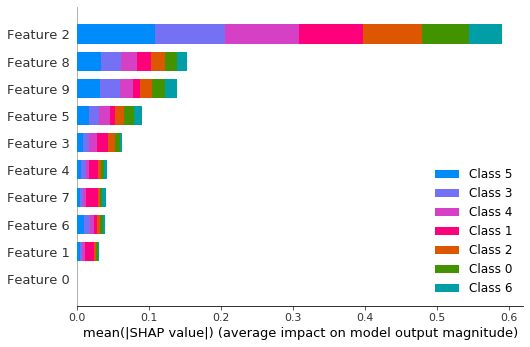

In [169]:
model_v.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 32)                352       
_________________________________________________________________
dense_43 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_44 (Dense)             (None, 7)                 119       
Total params: 999
Trainable params: 999
Non-trainable params: 0
_________________________________________________________________


In [113]:
history_dict=history_v.history

loss_v=history_dict['loss']
val_loss_v=history_dict['val_loss']

epochs=range(1,len(loss_v)+1)

acc_v=history_dict['accuracy']
val_acc_v=history_dict['val_accuracy']

auc_v=history_dict['auc']
val_auc_v=history_dict['val_auc']

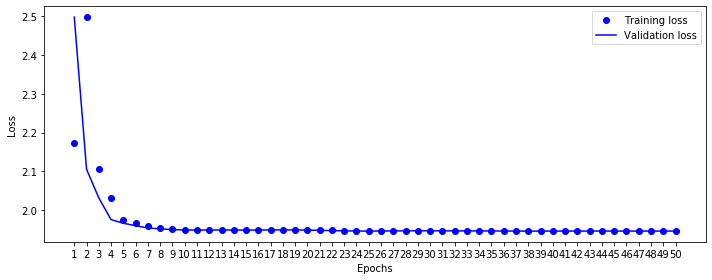

In [114]:
plt.figure(figsize=(10,4))
plt.plot(epochs,loss_v,'bo',label='Training loss')
plt.plot(epochs,val_loss_v,'b',label='Validation loss')
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
#plt.savefig('./Result/New_without_CNN/loss_vowel_'+save_specifier+'.svg',format='svg', dpi=600)

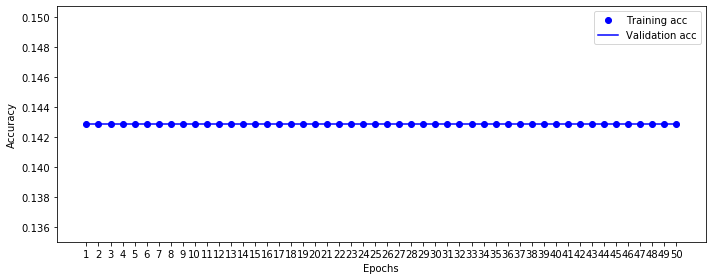

In [115]:
plt.figure(figsize=(10,4))
plt.plot(epochs,acc_v,'bo',label='Training acc')
plt.plot(epochs,val_acc_v,'b',label='Validation acc')
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
#plt.savefig('./Result/New_without_CNN/accuracy_vowel_'+save_specifier+'.svg',format='svg', dpi=600)

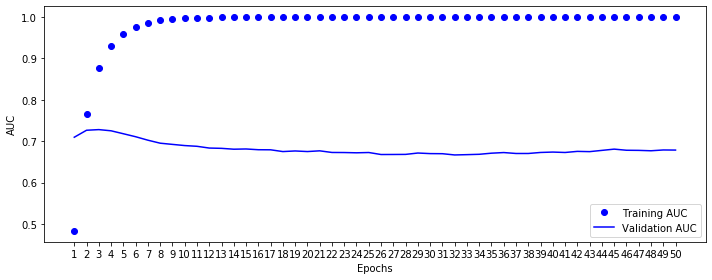

In [72]:
plt.figure(figsize=(10,4))
plt.plot(epochs,auc_v,'bo',label='Training AUC')
plt.plot(epochs,val_auc_v,'b',label='Validation AUC')
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.tight_layout()
#plt.savefig('./Result/New_without_CNN/AUC_vowel_'+save_specifier+'.svg',format='svg', dpi=600)

In [73]:
DATA_PATH="./Word_Data/Formant/"

In [74]:
def get_formant(file_path):
    formant=pd.read_csv(file_path,
                delim_whitespace=True,
                header=None,
                names=["time","F1","F2","F3","F4","F5"],
                dtype=np.float64,
                na_values="--undefined--")
    return formant

def get_all_formants(path=DATA_PATH):
    labels=labels=sorted(os.listdir(path))
    all_formant=pd.DataFrame() #empty dataframe to store all_formants
    
    for label_index,label in enumerate(labels):
        folder_formant=pd.DataFrame() #empty dataframe to store formants of indivuals vowels/words i.e. folders

        formant_files=[path + label + '/' + file for file in sorted(os.listdir(path+'/'+label))]
        for file in tqdm(formant_files,"Reading Formants of label -'{}'".format(label)):
            #print(file)
            individual_formant=get_formant(file_path=file)
  
            length=len(individual_formant)
            F_i=individual_formant.loc[2:,'F1':'F5'].values
            F_i1=individual_formant.loc[1:length-2,'F1':'F5'].values
            F_i2=individual_formant.loc[:length-3,'F1':'F5'].values
            assert len(F_i)==len(F_i1)==len(F_i2)
            individual_formant.loc[2:,['F1_diff2','F2_diff2','F3_diff2','F4_diff2','F5_diff2']]=F_i-2*F_i1+F_i2
            
            individual_formant=individual_formant.dropna()   #drop the first two rows as there are NaN values due to the difference
            
            folder_formant=folder_formant.append(individual_formant,ignore_index=True)
        
        folder_formant['disp(F5-F1)']=folder_formant['F5']-folder_formant['F1']
        folder_formant['disp(F4-F3)']=folder_formant['F4']-folder_formant['F3']
        folder_formant['disp(F5-F3)']=folder_formant['F5']-folder_formant['F3']
        folder_formant['disp(F5-F4)']=folder_formant['F5']-folder_formant['F4']
        
        folder_formant['label']=label_index  #new columns for encoding label
        
        all_formant=all_formant.append(folder_formant,ignore_index=True)     
    return all_formant

def get_train_test(split_ratio=0.8,random_state=42):
    all_formants=get_all_formants()
    
    y=all_formants['label'].values
 
    only_formants=all_formants.drop(labels=['label'],axis=1)
    
    normalized_formants=(only_formants-only_formants.mean())/only_formants.std()
    
    X=normalized_formants.values   

    assert X.shape[0] == len(y)
    return train_test_split(X,y,test_size=(1-split_ratio),random_state=random_state,shuffle=True,stratify=y)

In [75]:
np.random.seed(seed)
X_train, X_test, y_train, y_test=get_train_test()
y_train_hot=to_categorical(y_train)
y_test_hot=to_categorical(y_test)

Reading Formants of label -'Formant7': 100%|██████████| 40/40 [00:00<00:00, 103.61it/s]


In [76]:
model_w=Sequential()
#model_w.add(Dense(128, activation='tanh', input_shape=(6,)))
#model_w.add(Dense(64, activation='tanh'))
model_w.add(Dense(32, activation='tanh',input_shape=(X_train.shape[1],)))
model_w.add(Dense(16, activation='tanh'))
model_w.add(Dense(7, activation='softmax'))

In [77]:
model_w.compile(
    #optimizer=opt.SGD(learning_rate=0.005,momentum=0.9),
    optimizer=opt.Adam(learning_rate=0.005),
    #loss=losses.CategoricalCrossentropy(),
    loss='categorical_crossentropy',
    #metrics=['AUC'],
    #metrics=['accuracy']#,
    metrics=[['accuracy','AUC']]
)

In [78]:
history_w=model_w.fit(X_train, y_train_hot, epochs=50, batch_size=X_train.shape[0], validation_data=(X_test,y_test_hot))

Epoch 1/50
1/1 [==============================] - 0s 382ms/step - loss: 2.0808 - accuracy: 0.1357 - auc: 0.4989 - val_loss: 2.0295 - val_accuracy: 0.1519 - val_auc: 0.5135
Epoch 2/50
1/1 [==============================] - 0s 104ms/step - loss: 2.0221 - accuracy: 0.1514 - auc: 0.5215 - val_loss: 1.9772 - val_accuracy: 0.1814 - val_auc: 0.5420
Epoch 3/50
1/1 [==============================] - 0s 108ms/step - loss: 1.9714 - accuracy: 0.1833 - auc: 0.5488 - val_loss: 1.9332 - val_accuracy: 0.2216 - val_auc: 0.5719
Epoch 4/50
1/1 [==============================] - 0s 126ms/step - loss: 1.9292 - accuracy: 0.2190 - auc: 0.5774 - val_loss: 1.8974 - val_accuracy: 0.2533 - val_auc: 0.5983
Epoch 5/50
1/1 [==============================] - 0s 103ms/step - loss: 1.8951 - accuracy: 0.2446 - auc: 0.6026 - val_loss: 1.8687 - val_accuracy: 0.2710 - val_auc: 0.6198
Epoch 6/50
1/1 [==============================] - 0s 116ms/step - loss: 1.8682 - accuracy: 0.2582 - auc: 0.6230 - val_loss: 1.8458 - val_acc

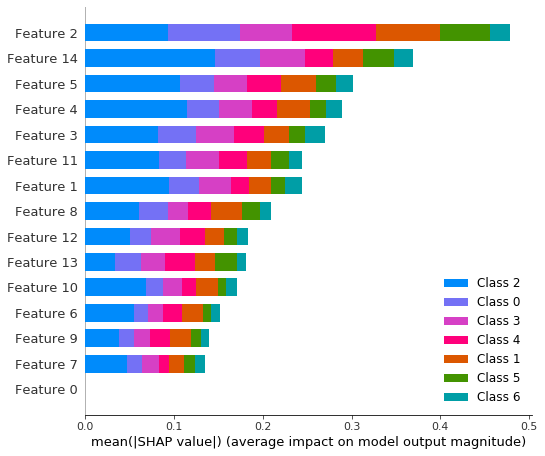

In [86]:
e=shap.DeepExplainer(model_w,X_test)
shape_values=e.shap_values(X_test)
shap.summary_plot(shape_values,X_test)

In [79]:
history_dict=history_w.history
loss_w=history_dict['loss']
val_loss_w=history_dict['val_loss']

epochs=range(1,len(loss_v)+1)

acc_w=history_dict['accuracy']
val_acc_w=history_dict['val_accuracy']

auc_w=history_dict['auc']
val_auc_w=history_dict['val_auc']

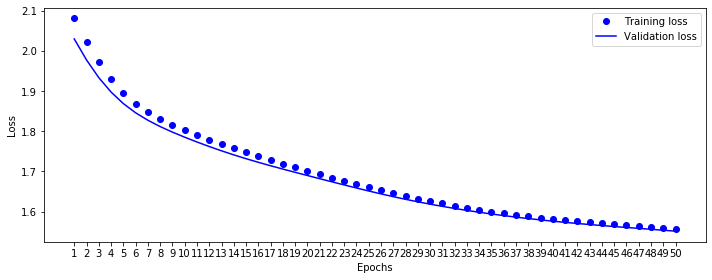

In [80]:
plt.figure(figsize=(10,4))
plt.plot(epochs,loss_w,'bo',label='Training loss')
plt.plot(epochs,val_loss_w,'b',label='Validation loss')
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
#plt.savefig('./Result/New_without_CNN/loss_word_'+save_specifier+'.svg',format='svg', dpi=600)

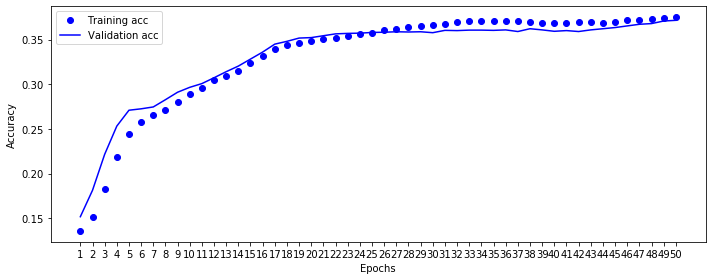

In [81]:
plt.figure(figsize=(10,4))
plt.plot(epochs,acc_w,'bo',label='Training acc')
plt.plot(epochs,val_acc_w,'b',label='Validation acc')
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
#plt.savefig('./Result/New_without_CNN/accuracy_word_'+save_specifier+'.svg',format='svg', dpi=600)

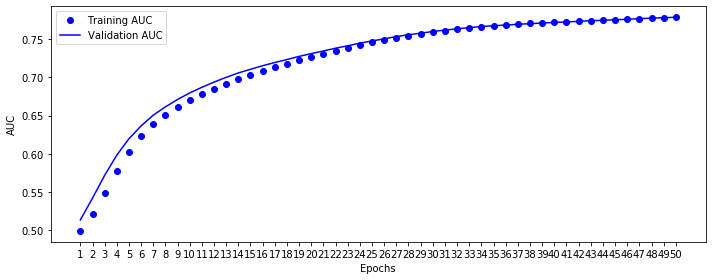

In [82]:
plt.figure(figsize=(10,4))
plt.plot(epochs,auc_w,'bo',label='Training AUC')
plt.plot(epochs,val_auc_w,'b',label='Validation AUC')
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.tight_layout()
#plt.savefig('./Result/New_without_CNN/AUC_word_'+save_specifier+'.svg',format='svg', dpi=600)

In [83]:
#COMPARE

In [84]:
epochs=range(1,len(loss_v)+1)

In [85]:
save_specifier='fromant_diff_disp_32_16_tanh_softmax_adam_0.005_batchfull_scaled'

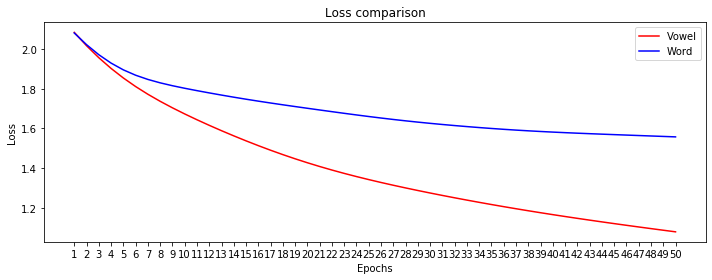

In [86]:
#sns.reset()
#sns.reset_orig()
plt.figure(figsize=(10,4))
plt.plot(epochs,loss_v,'r',label='Vowel')
plt.plot(epochs,loss_w,'b',label='Word')
plt.title('Loss comparison')
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('./Result/New_without_CNN/loss_compare_'+save_specifier+'.pdf',format='pdf',dpi=600)

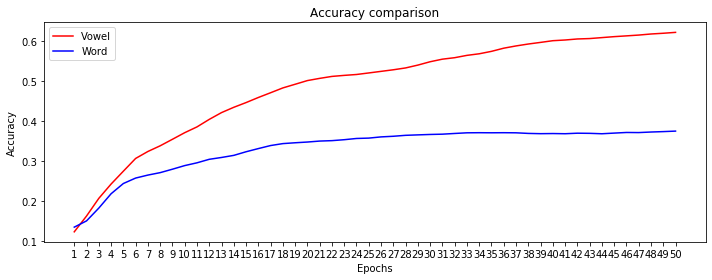

In [87]:
plt.figure(figsize=(10,4))
plt.plot(epochs,acc_v,'r',label='Vowel')
plt.plot(epochs,acc_w,'b',label='Word')
plt.title('Accuracy comparison')
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig('./Result/New_without_CNN/accuracy_compare_'+save_specifier+'.pdf',format='pdf',dpi=600)

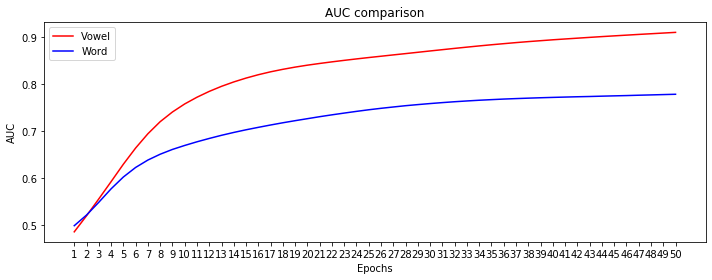

In [88]:
plt.figure(figsize=(10,4))
plt.plot(epochs,auc_v,'r',label='Vowel')
plt.plot(epochs,auc_w,'b',label='Word')
plt.title('AUC comparison')
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.tight_layout()
plt.savefig('./Result/New_without_CNN/AUC_compare_'+save_specifier+'.pdf',format='pdf',dpi=600)

In [89]:
all_compare_df=pd.DataFrame({'loss_v':loss_v,
                      'val_loss_v':val_loss_v,
                      'acc_v':acc_v,
                      'val_acc_v':val_acc_v,
                      'auc_v':auc_v,
                      'val_auc_v':val_auc_v,
                      'loss_w':loss_w,
                      'val_loss_w':val_loss_w,
                      'acc_w':acc_w,
                      'val_acc_w':val_acc_w,
                      'auc_w':auc_w,
                      'val_auc_w':val_auc_w
                     })

all_compare_df.to_csv('./Result/New_without_CNN/all_compare_data_'+save_specifier+'.csv')

In [144]:
all_compare_df.tail()

,loss_v,val_loss_v,acc_v,val_acc_v,auc_v,val_auc_v,loss_w,val_loss_w,acc_w,val_acc_w,auc_w,val_auc_w
45,1.510234,1.498732,0.366437,0.370279,0.796772,0.800146,1.708708,1.714930,0.303956,0.299898,0.720853,0.715563
46,1.504479,1.498546,0.365201,0.367102,0.797813,0.798793,1.707437,1.713586,0.305353,0.300660,0.721409,0.716229
47,1.500465,1.493217,0.364848,0.376633,0.798146,0.801928,1.706840,1.713536,0.305924,0.298121,0.721904,0.715366
48,1.497878,1.487364,0.368114,0.381221,0.799064,0.803229,1.704514,1.714414,0.304591,0.297613,0.721866,0.713816
49,1.493867,1.477454,0.372881,0.384045,0.799755,0.805838,1.703115,1.715560,0.304019,0.295328,0.721080,0.712323


In [40]:
all_compare_df.tail()

,loss_v,val_loss_v,acc_v,val_acc_v,auc_v,val_auc_v,loss_w,val_loss_w,acc_w,val_acc_w,auc_w,val_auc_w
45,1.411883,1.405710,0.447034,0.461701,0.833349,0.836040,1.781247,1.795952,0.276208,0.262062,0.681543,0.670234
46,1.397944,1.405708,0.465660,0.461701,0.838839,0.836425,1.781183,1.794109,0.273224,0.264093,0.679729,0.671856
47,1.398288,1.398337,0.465749,0.469820,0.838970,0.838291,1.782951,1.789811,0.272017,0.279584,0.678212,0.675529
48,1.396289,1.386209,0.470251,0.492411,0.839035,0.842212,1.780074,1.782680,0.288463,0.283647,0.680309,0.680218
49,1.383023,1.377770,0.486405,0.498412,0.843179,0.843809,1.774793,1.775333,0.290939,0.297359,0.684268,0.684437


In [78]:
all_compare_df.tail()

,loss_v,val_loss_v,acc_v,val_acc_v,auc_v,val_auc_v,loss_w,val_loss_w,acc_w,val_acc_w,auc_w,val_auc_w
45,1.645361,1.635071,0.321140,0.318265,0.761262,0.764530,1.794142,1.795046,0.296517,0.292995,0.686432,0.684662
46,1.628057,1.626682,0.320772,0.325983,0.768138,0.769586,1.791320,1.788053,0.302791,0.312337,0.687685,0.687996
47,1.615787,1.615028,0.326379,0.358692,0.774701,0.773985,1.786905,1.775738,0.318541,0.320178,0.689430,0.694610
48,1.608039,1.607040,0.355607,0.356487,0.777154,0.774983,1.776664,1.769562,0.327103,0.317825,0.694150,0.696794
49,1.598885,1.596370,0.358548,0.360529,0.778704,0.778123,1.770723,1.765198,0.325404,0.308677,0.695664,0.698677


In [90]:
all_compare_df.tail()

,loss_v,val_loss_v,acc_v,val_acc_v,auc_v,val_auc_v,loss_w,val_loss_w,acc_w,val_acc_w,auc_w,val_auc_w
45,1.112686,1.118910,0.612776,0.613377,0.904947,0.902697,1.566870,1.560570,0.371871,0.365395,0.776166,0.776080
46,1.104304,1.110964,0.614798,0.614112,0.906490,0.904161,1.564591,1.558269,0.371610,0.367224,0.776922,0.776914
47,1.096042,1.103127,0.617463,0.615583,0.907929,0.905562,1.562321,1.555987,0.372982,0.368008,0.777572,0.777548
48,1.087889,1.095378,0.619301,0.617420,0.909399,0.906913,1.560057,1.553699,0.374028,0.370883,0.778273,0.778163
49,1.079837,1.087704,0.621507,0.619625,0.910848,0.908233,1.557797,1.551383,0.375270,0.371668,0.778951,0.778717
